In [1]:
from utils import *
from fastai2.vision.all import *
from os import scandir, replace

In [2]:
superclass = 'cat', 'dog'
path = Path('images')
for o in superclass:
    tpath = (path/o)
    if not tpath.exists():
        tpath.mkdir(exist_ok=True)

In [3]:
path.ls()

(#2) [Path('images/cat'),Path('images/dog')]

In [4]:
# look if it can be optimized with regex
with scandir(path) as listOfEntries:
    for entry in listOfEntries:
        if entry.is_file():
            if entry.name[0].isupper():
                tpath = (path/'cat')
            else:
                tpath = (path/'dog')
            x = entry.name.rfind('_')
            class_entry = entry.name[:x]
            temp_path = (tpath/class_entry)
            if not temp_path.exists():
                temp_path.mkdir(exist_ok=True)
            replace(path/entry.name, temp_path/entry.name)

In [7]:
fns = get_image_files(path)
fns

(#7390) [Path('images/cat/Sphynx/Sphynx_241.jpg'),Path('images/cat/Sphynx/Sphynx_8.jpg'),Path('images/cat/Sphynx/Sphynx_137.jpg'),Path('images/cat/Sphynx/Sphynx_25.jpg'),Path('images/cat/Sphynx/Sphynx_31.jpg'),Path('images/cat/Sphynx/Sphynx_19.jpg'),Path('images/cat/Sphynx/Sphynx_18.jpg'),Path('images/cat/Sphynx/Sphynx_30.jpg'),Path('images/cat/Sphynx/Sphynx_24.jpg'),Path('images/cat/Sphynx/Sphynx_122.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#0) []

In [9]:
failed.map(Path.unlink)

(#0) []

In [14]:
cat_dog = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [17]:
cat_dog.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      images/dog/german_shorthaired/german_shorthaired_109.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x335
  Pipeline: parent_label -> Categorize
    starting from
      images/dog/german_shorthaired/german_shorthaired_109.jpg
    applying parent_label gives
      german_shorthaired
    applying Categorize gives
      TensorCategory(20)

Final sample: (PILImage mode=RGB size=500x335, TensorCategory(20))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB 

/Users/jacopoclocchiatti/opt/anaconda3/envs/cat_dog_class/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [18]:
dls = cat_dog.dataloaders(path)

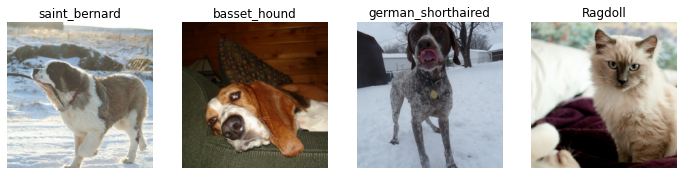

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

# General Approach

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

RuntimeError: DataLoader worker (pid(s) 39310, 39312, 39314, 39316) exited unexpectedly

In [26]:
x,y = dls.one_batch()
y

TensorCategory([28,  3, 19, 15, 15, 11, 18, 29, 32, 28, 15, 21, 10, 19,  9, 21, 35, 25,
         3, 34, 17, 36,  8, 35,  8, 15, 15, 32, 15, 15,  6, 26, 21,  1, 14,  6,
        22,  3, 16,  8, 24, 13, 18, 27, 34, 20,  5, 10, 36, 22, 31,  4, 35,  4,
        12, 21, 24, 26,  2, 24, 12, 22, 25,  9])

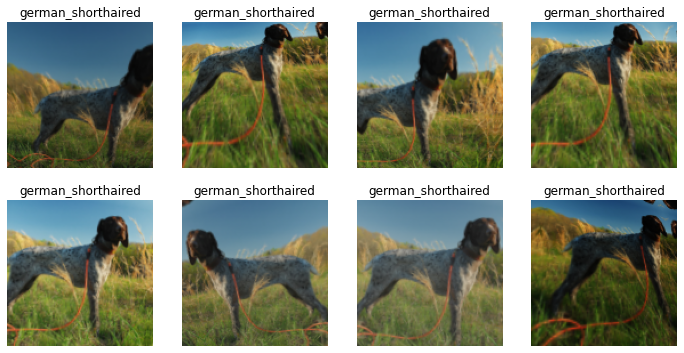

In [27]:
cat_dog_1 = cat_dog.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls_1 = cat_dog_1.dataloaders(path)
dls_1.train.show_batch(max_n=8, nrows=2, unique=True)

In [52]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

RuntimeError: DataLoader worker (pid(s) 49258, 49260, 49263, 49265) exited unexpectedly

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(fig_size=(20,20), dpi=60)

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
interp.most_confused(min_val=5)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Learning Rate finder

In [ ]:
learn = cnn_learner.(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=) # TODO

# Unfreezing and Transfer Learning

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, ) #TODO 

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=) #TODO

# Discriminative Learning Rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lear.fit_one_cycle(3, ) #TODO
learn.unfreeze()
learnn.fit_one_cycle(12, lr_max=slice()) #TODO

In [ ]:
learn.recorder.plot_loss()

# Mixed-precision training

In [ ]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)